This is to generate the relevant data from the exact diagonalziation that I myself coded

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import UnivariateSpline

import os
import sys  

from ast import literal_eval

from qutip import  *

sys.path.append('../../scripts') 

from qutip_tools import *

In [2]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 20

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../plots/QPC_double_dot/"


In [3]:
data_route = "../../data/exact_diag_new/L=40/"

J=1


In [4]:
def get_time_at_bond(Times, N_bond):
    """ we estimate the time the qpc wavepacket spends at the bond with the qubit from the  FWHM of the
    occupations at the bond sites as a function of time """
    
    # estimate FWHF with an interpolation
    spline = UnivariateSpline(Times, N_bond - np.max(N_bond) / 2, s=0)
    bond_root = spline.roots()  # find the roots
    if (len(bond_root) < 2):
        print("not possible to estimate time at bond for ")
        print(Param_dict)
        tau_b = -Times[-1]
    else:
        # the first two roots yield the width at half maximum
        tau_b = bond_root[1] - bond_root[0]
    return tau_b


# Checking correct initial condition

Here we make sure that the occupation of the qubit 0 state is at roughly the same  for all different velocities. We achieve this by tweaking the initial conditions at at $\Omega=0$

In [5]:
# file_list = get_file_names_on(["om0.1","bw2.0","t0.1", "dd0fixed"], data_route)
file_list = get_file_names_on(["om0.0","Del4.0","t0.1"], data_route)

file_list

['exact_L40_J1.0_t0.1_om0.0_Del4.0_xo5_k0.9425_bindex20_maxtau70.000_tstep0.140_alpha0.265_beta0.735_phi0.0.h5',
 'exact_L40_J1.0_t0.1_om0.0_Del4.0_xo5_k0.1571_bindex20_maxtau70.000_tstep0.140_alpha0.793_beta0.207_phi0.0.h5',
 'exact_L40_J1.0_t0.1_om0.0_Del4.0_xo5_k0.3142_bindex20_maxtau70.000_tstep0.140_alpha0.795_beta0.205_phi0.0.h5',
 'exact_L40_J1.0_t0.1_om0.0_Del4.0_xo5_k1.4923_bindex20_maxtau70.000_tstep0.140_alpha0.373_beta0.627_phi0.0.h5',
 'exact_L40_J1.0_t0.1_om0.0_Del4.0_xo5_k0.7854_bindex20_maxtau70.000_tstep0.140_alpha0.215_beta0.785_phi0.0.h5',
 'exact_L40_J1.0_t0.1_om0.0_Del4.0_xo5_k1.2566_bindex20_maxtau70.000_tstep0.140_alpha0.348_beta0.652_phi0.0.h5',
 'exact_L40_J1.0_t0.1_om0.0_Del4.0_xo5_k0.4712_bindex20_maxtau70.000_tstep0.140_alpha0.409_beta0.591_phi0.0.h5',
 'exact_L40_J1.0_t0.1_om0.0_Del4.0_xo5_k1.0996_bindex20_maxtau70.000_tstep0.140_alpha0.313_beta0.687_phi0.0.h5',
 'exact_L40_J1.0_t0.1_om0.0_Del4.0_xo5_k1.4137_bindex20_maxtau70.000_tstep0.140_alpha0.368_beta0

Text(0.5, 0, 'Time')

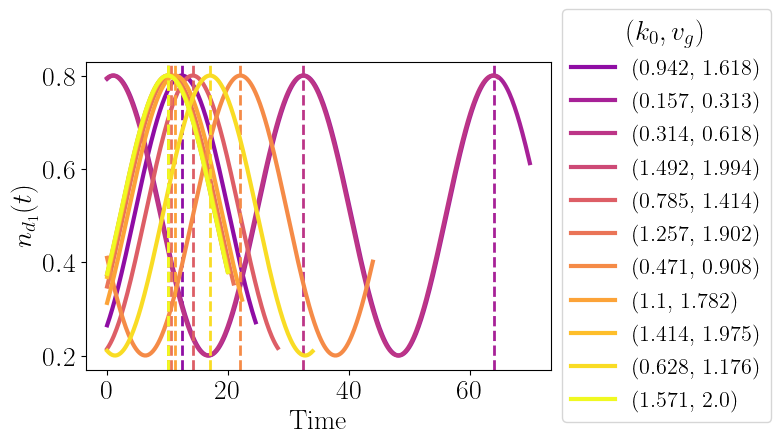

In [6]:
colors = plt.cm.plasma(np.linspace(0.3,1,len(file_list)))

fig, ax = plt.subplots(figsize=(6,4))

for i in range(0,len(file_list)):
    file_name = file_list[i]
    param_dict, times, occupations, d0_density, qubit_rho, entropy = load_exact_diag(data_route, file_name)  
  
    # calculate the time it takes it to hit the bond (scattering approx)
    vg = 2*np.sin(param_dict["K0"])
    tau_to_bond = param_dict["bond_index"]/vg
    
    lab = "("+str(round(param_dict["K0"],3)) + ", " + str(round(vg,3))+")" 
    
    plt.plot(times, d0_density, linewidth=3, label=lab , c=colors[i])
    
    plt.axvline(tau_to_bond, linestyle="dashed",c=colors[i], linewidth=2)
    
plt.legend(title=r"$(k_0, v_g)$",loc='center left', bbox_to_anchor=(1, 0.5))

plt.ylabel(r"$n_{d_1}(t)$")
plt.xlabel(r"Time")



# Generating Analysis dataframe

Here we put all the processed and raw data in a dataframe for convenient reading abd analysis

In [7]:

def get_bloch_angles(ρ_list):
    # Calculate the Bloch angles for each time step

    theta_list = []
    phi_list = []
    for i in range(0,len(ρ_list)):
        # mixed state bloch sphere representation. Check page 34 of my notes for this 
        r = ρ_list[i]
        Cos_theta_p = 2*r[0,0] - 1
        theta_p = np.arccos(Cos_theta_p)
        Sin_phi_p = (r[1,0] - r[0,1])/(1j*np.sin(theta_p))
        
        theta_list.append(Cos_theta_p)
        phi_list.append(Sin_phi_p)
        
    return theta_list, phi_list

In [8]:
file_list = get_file_names_on([], data_route)
file_list

['exact_L40_J1.0_t0.05_om0.0_Del4.0_xo5_k1.2566_bindex20_maxtau70.000_tstep0.140_alpha0.649_beta0.351_phi0.0.h5',
 'exact_L40_J1.0_t2.0_om0.3_Del4.0_xo5_k0.7854_bindex20_maxtau70.000_tstep0.140_alpha0.800_beta0.200_phi0.0.h5',
 'exact_L40_J1.0_t0.2_om0.7_Del4.0_xo5_k1.4923_bindex20_maxtau70.000_tstep0.140_alpha0.307_beta0.693_phi0.0.h5',
 'exact_L40_J1.0_t0.09_om0.1_Del4.0_xo5_k1.4137_bindex20_maxtau70.000_tstep0.140_alpha0.425_beta0.575_phi0.0.h5',
 'exact_L40_J1.0_t0.01_om0.1_Del4.0_xo5_k0.3142_bindex20_maxtau70.000_tstep0.140_alpha0.739_beta0.261_phi0.0.h5',
 'exact_L40_J1.0_t0.2_om0.5_Del4.0_xo5_k1.4137_bindex20_maxtau70.000_tstep0.140_alpha0.315_beta0.685_phi0.0.h5',
 'exact_L40_J1.0_t1.5_om0.5_Del4.0_xo5_k0.7854_bindex20_maxtau70.000_tstep0.140_alpha0.504_beta0.496_phi0.0.h5',
 'exact_L40_J1.0_t0.6_om0.7_Del4.0_xo5_k1.2566_bindex20_maxtau70.000_tstep0.140_alpha0.800_beta0.200_phi0.0.h5',
 'exact_L40_J1.0_t0.6_om0.7_Del4.0_xo5_k1.0996_bindex20_maxtau70.000_tstep0.140_alpha0.686_be

In [9]:
# read the parameter dictionary to initialize 
param_dict, times, occupations, d0_density, qubit_rho, entropy = load_exact_diag(data_route, file_list[0])  

data_dict =  {key: [] for key in param_dict}
data_dict["times"] = []
data_dict["occupations"] = []
data_dict["d0_density"] = []
data_dict["qubit_rho"] = []
data_dict["entropy"] = []
data_dict["time_at_bond"] = []
data_dict["Max_entropy"] = []
data_dict["cos_theta"] = []
data_dict["sin_phi"] = []

for i in range(0,len(file_list)):
    file_name = file_list[i]
    param_dict, times, occupations, d0_density, qubit_rho, entropy = load_exact_diag(data_route, file_name) 
    # initialize the meta data
    for key in param_dict.keys():
        data_dict[key].append(param_dict[key])

    #  estimate the time that wavepacket spends at bondf
    bond_density = occupations[param_dict["bond_index"], :] + occupations[param_dict["bond_index"]+1, :]
    tau_bond = get_time_at_bond(times, bond_density)
    
    # get the bloch angles fo the qubit
    theta_list, phi_list = get_bloch_angles(qubit_rho)

    # save raw data 
    data_dict["times"].append(times.astype(np.float32))
    data_dict["occupations"].append(occupations.astype(np.float32))
    data_dict["d0_density"].append(d0_density.astype(np.float32)) 
    data_dict["qubit_rho"].append(qubit_rho.astype(np.complex64))
    # normalize entropy by maximally entangled singled 
    data_dict["entropy"].append((entropy/np.log(2)).astype(np.float32)) 
    # save processed data
    data_dict["time_at_bond"].append(tau_bond)
    data_dict["Max_entropy"].append(max(entropy/np.log(2)))
    data_dict["cos_theta"].append(theta_list)
    data_dict["sin_phi"].append(phi_list)

data_df = pd.DataFrame.from_dict(data_dict)

In [10]:
data_df["X0"]

0      5
1      5
2      5
3      5
4      5
      ..
765    5
766    5
767    5
768    5
769    5
Name: X0, Length: 770, dtype: int64

# Entropy Production

In [11]:
t_ = 0.05
Om_ = 0.3
# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_) & (data_df["t"]==t_)

curr_df = data_df[cond_].sort_values(by="K0")


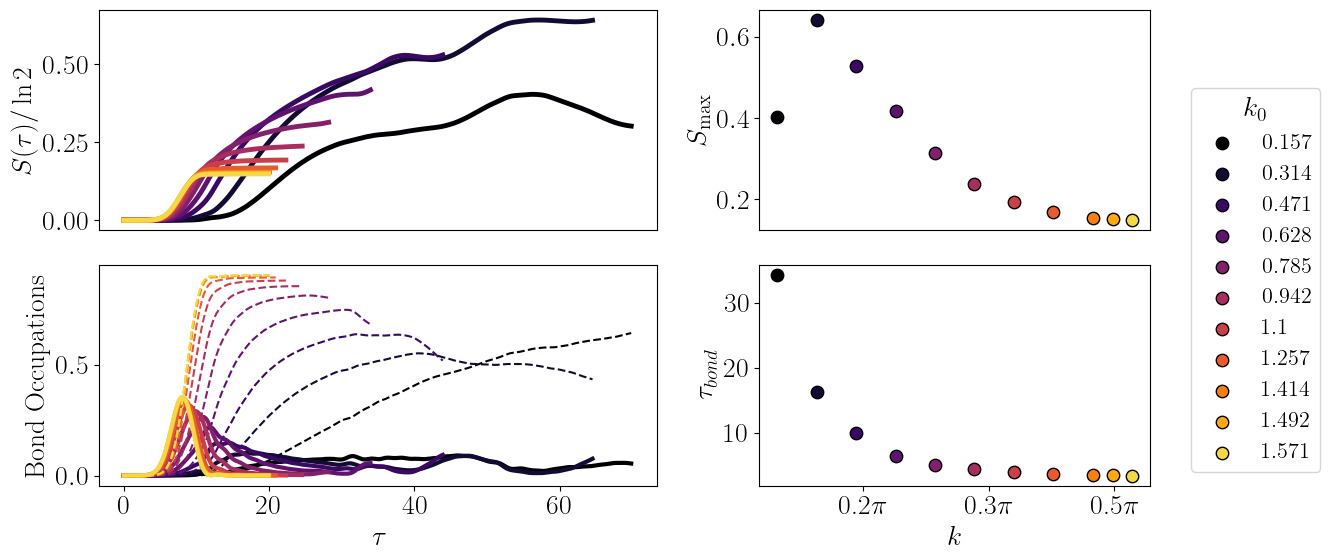

In [12]:
# Create 2x2 sub plots

fig = plt.figure(figsize=(12,6))

#plt.suptitle(om_s + ", " + bw_s + ", " + t_s )
gs = gridspec.GridSpec(2, 2, width_ratios=[1,0.7])
K0_unique = curr_df["K0"].unique()
colors = plt.cm.inferno(np.linspace(0.0,0.9,len(K0_unique)))

for i in range(0,len(K0_unique)):
    # generate the legend
    lab = str(round(K0_unique[i],3))
    # Entropy in time
    ax = plt.subplot(gs[0, 0]) # make it span both columns
    xvals = curr_df[curr_df["K0"]== K0_unique[i]]["times"].item()
    yvals = curr_df[curr_df["K0"]== K0_unique[i]]["entropy"].item()
    ax.plot(xvals,yvals, linewidth=3.5, c=colors[i])
    
    # max entropy
    ax = plt.subplot(gs[0, 1])
    ax.scatter(K0_unique[i], max(yvals), c=[colors[i]], s=80, edgecolor='black', zorder=7,label=lab)
    
    # plot density at the bond in time and transmission
    bindex = curr_df[curr_df["K0"]== K0_unique[i]]["bond_index"].item()
    occ_matrix = curr_df[curr_df["K0"]== K0_unique[i]]["occupations"].item()
    bond_density = occ_matrix[bindex, :] + occ_matrix[bindex+1, :] 
    transmission = np.sum(occ_matrix[bindex+2:,:], axis=0)
    
    ax = plt.subplot(gs[1, 0]) # row 1, col 0
    ax.plot(xvals,bond_density, linewidth=3, c=colors[i])    
    ax.plot(xvals, transmission, linestyle="dashed", linewidth=1.5, c=colors[i])
    # plot time spent at bond
    ax = plt.subplot(gs[1, 1]) # row 1, col 1
    ax.scatter(K0_unique[i], curr_df[curr_df["K0"]== K0_unique[i]]["time_at_bond"], c=[colors[i]], s=80, edgecolor='black', zorder=7)





# Set up labels and legends

plt.subplot(gs[0, 0]).set_ylabel(r"$S(\tau)/\ln{2}$")
plt.subplot(gs[0, 0]).set_xticks([])

plt.subplot(gs[0, 1]).set_xticks([])
plt.subplot(gs[0, 1]).set_ylabel(r"$S_{\rm{max}}$")
# plt.subplot(gs[0, 1]).legend(title=r"$k_0$", loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.legend(title=r"$k_0$", loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.subplot(gs[1, 0]).set_ylabel(r"Bond Occupations")
plt.subplot(gs[1, 0]).set_xlabel(r"$\tau$")

plt.subplot(gs[1, 1]).set_ylabel(r"$\tau_{bond}$")
plt.subplot(gs[1, 1]).set_xlabel(r"$k$")
# write x axis in units of pi
plt.subplot(gs[1, 1]).xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

plt.subplots_adjust(wspace=0.16, hspace=0.09)

plt.tight_layout()

Looking in more detail at those weird trajectories for the slower momenta may be useful

In [13]:
k0_list = np.sort(data_df["K0"].unique())
print(k0_list)
k0_ = k0_list[3]

# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_) & (data_df["t"]==t_) & (data_df["K0"]==k0_)

curr_df = data_df[cond_]
curr_df

[0.15707963 0.31415927 0.4712389  0.62831853 0.78539816 0.9424778
 1.09955743 1.25663706 1.41371669 1.49225651 1.57079633]


,L_qpc,Omega,t,J,Jp,bond_index,K0,X0,Spread,maxt_time,...,phi,times,occupations,d0_density,qubit_rho,entropy,time_at_bond,Max_entropy,cos_theta,sin_phi
38,40,0.3,0.05,1.0,1.0,20,0.628319,5,4.0,70.0,...,0.0,"[0.0, 0.14028056, 0.28056112, 0.4208417, 0.561...","[[0.030332765, 0.023903392, 0.018055016, 0.013...","[0.46095946, 0.46513578, 0.469319, 0.4735082, ...","[[[(0.46095946+5.5671e-19j), (0.4+0.29744887j)...","[-5.766168e-15, 2.3747377e-09, 1.0420034e-08, ...",6.388115,0.41687,[(-0.07808109136118424+1.1134199899507591e-18j...,"[(-0.5967195366397633+5.219525151127615e-20j),..."


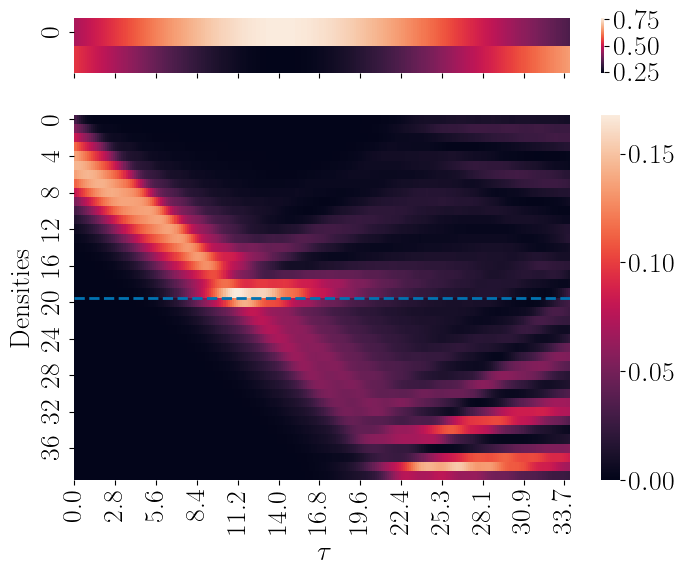

In [14]:
fig, ax = plt.subplots(2,1,figsize=(8,6), sharex=True ,gridspec_kw={'height_ratios': [0.15, 1]})

# n_d1
n_d1 = curr_df["d0_density"].item()
sns.heatmap([n_d1,1-n_d1],ax=ax[0])
traj_matrix = curr_df["occupations"].item()
time_range = curr_df["times"].item()
sns.heatmap(traj_matrix,ax=ax[1])

ax[1].set_xlabel(r"$\tau$")

ax[1].set_ylabel("Densities")

# time ticks
delta_tau = time_range[1] - time_range[0]
tick_posx = np.arange(0,len(time_range),20)
xtick_label = np.around(tick_posx*(delta_tau),decimals=1)

ax[1].axhline(curr_df["bond_index"].item(), linewidth=2, linestyle="dashed")
ax[1].set_xticks(tick_posx,xtick_label);


# Phase diagram

In [15]:

# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_) & (data_df["K0"]>0.0) & (data_df["t"]<3)

data_S = data_df[cond_].sort_values(by="K0")

S_df = data_S.pivot_table(index='K0', columns='t', values='Max_entropy', 
                          aggfunc='mean')

S_df

t,0.01,0.03,0.05,0.07,0.09,0.10,0.20,0.30,0.40,0.60,0.80,1.00,1.50,2.00
K0,,,,,,,,,,,,,,
0.157080,0.549979,0.555554,0.402857,0.262334,0.223889,0.184519,0.053693,0.032463,0.029519,0.036616,0.033176,0.011013,0.009111,0.003041
0.314159,0.499368,0.626679,0.640562,0.542704,0.365152,0.320010,0.132552,0.043579,0.032551,0.039379,0.025600,0.012980,0.009070,0.002887
0.471239,0.378695,0.460650,0.528732,0.546179,0.512098,0.478492,0.224948,0.115632,0.054509,0.022946,0.016491,0.015263,0.009111,0.002768
0.628319,0.311629,0.362388,0.416870,0.455635,0.470782,0.473828,0.354964,0.195513,0.106770,0.031565,0.016749,0.014133,0.007630,0.003816
0.785398,0.250477,0.278334,0.313338,0.348351,0.377399,0.388528,0.399549,0.298384,0.186596,0.067925,0.025167,0.015217,0.009476,0.004180
0.942478,0.204638,0.218623,0.237229,0.258518,0.280408,0.290993,0.354272,0.338825,0.269762,0.113888,0.046939,0.020759,0.009596,0.005138
1.099557,0.175387,0.182705,0.192655,0.204573,0.217684,0.224445,0.282744,0.306068,0.296165,0.186728,0.076398,0.035920,0.010440,0.005913
1.256637,0.157555,0.161707,0.167589,0.174839,0.183009,0.187291,0.226770,0.250968,0.264514,0.238848,0.131772,0.059325,0.011756,0.006726
1.413717,0.147799,0.150263,0.154086,0.158999,0.164651,0.167638,0.194511,0.208536,0.219819,0.238190,0.194614,0.093477,0.014608,0.007397


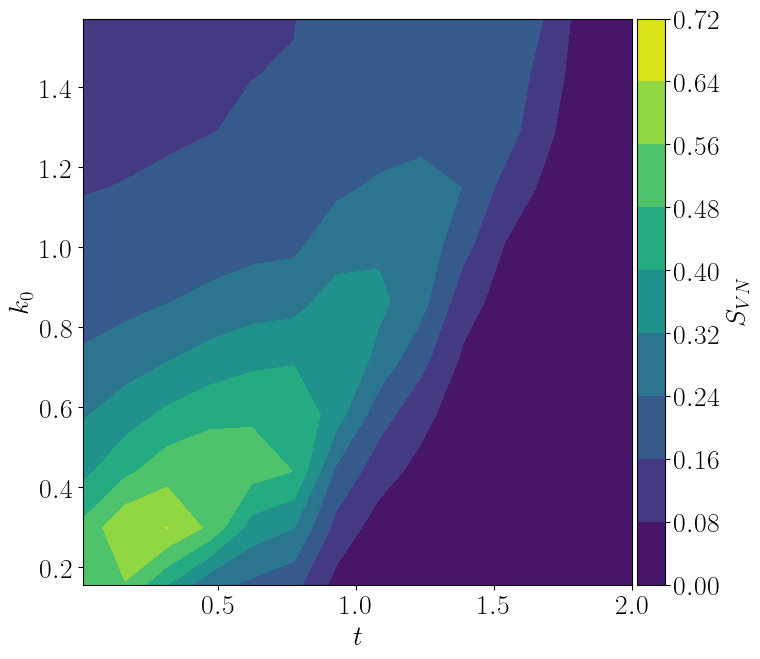

In [16]:
fig, ax = plt.subplots(1,1,figsize=(bwidth+1,bwidth))

vg_array = S_df.index
t_array = S_df.columns
im = ax.contourf(S_df.values,extent=[min(t_array), max(t_array),min(vg_array), max(vg_array)])

ax.set_ylabel(r"$k_0$")
ax.set_xlabel(r"$t$")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax, shrink=0.9)   
cbar.ax.set_ylabel(r'$S_{VN}$', rotation=90)

plt.tight_layout()


# Bloch Sphere

In [45]:
cond_ = (data_df["Omega"]==0.0) & (data_df["t"]==0.1)
curr_df = data_df[cond_]
data_df.columns


Index(['L_qpc', 'Omega', 't', 'J', 'Jp', 'bond_index', 'K0', 'X0', 'Spread',
       'maxt_time', 'del_tau', 'qubit_init', 'Re_qubit_0', 'Im_qubit_0',
       'Re_qubit_1', 'Im_qubit_1', 'phi', 'times', 'occupations', 'd0_density',
       'qubit_rho', 'entropy', 'time_at_bond', 'Max_entropy', 'cos_theta',
       'sin_phi'],
      dtype='object')

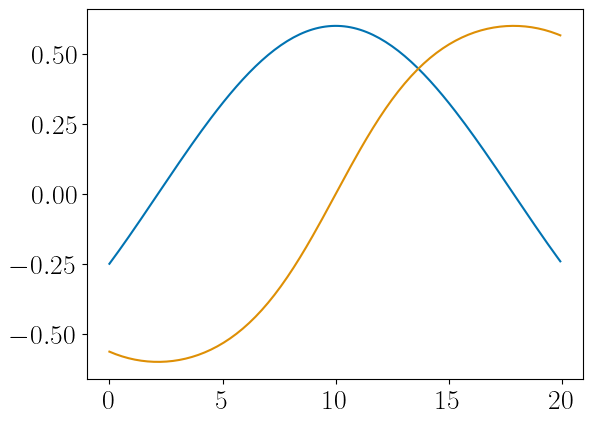

In [46]:
costheta = np.real(curr_df[curr_df["K0"]==k0_list[-1]]["cos_theta"].item())
sinphi = np.real(curr_df[curr_df["K0"]==k0_list[-1]]["sin_phi"].item())

xvals = np.real(curr_df[curr_df["K0"]==k0_list[-1]]["times"].item())

plt.plot(xvals, costheta)
plt.plot(xvals, sinphi)

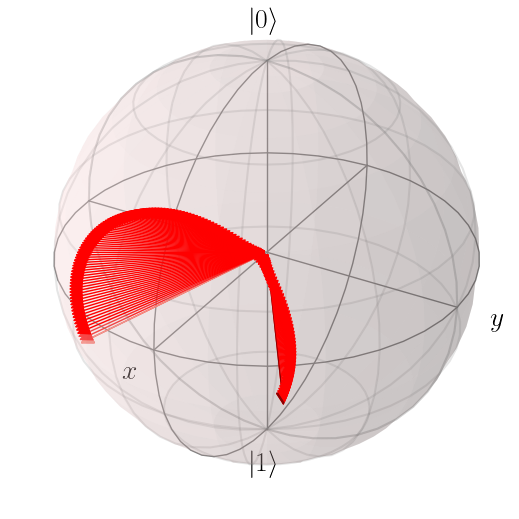

In [47]:
# Now plot the numerical coupled case
dd_theta = np.arccos(costheta)
dd_phi = np.arcsin(sinphi)

x_ = np.sin(dd_theta)*np.cos(dd_phi)
y_ = np.sin(dd_theta)*np.sin(dd_phi)
z_ = costheta

coupled_vectors = [[i,j,k] for i,j,k in zip(x_.real,y_.real,z_.real)]
# make all vectors the same color

bs = Bloch()

bs.add_vectors(coupled_vectors)
# now plot the first and last vectors and points in a different color
bs.add_vectors(coupled_vectors[0])
bs.add_vectors(coupled_vectors[-1])

bs.vector_color = ["red"]*len(coupled_vectors) + ["salmon", "darkred"]
bs.vector_width = 1.0

bs.show()